# gp2Scale 
gp2Scale is a special setting in gpCAM that combines non-stationary, compactly-supported kernels, HPC distributed computing, and sparse random linear algebra to allow scale-up of exact GPs to millions of data points. Here we run a moderately-sized GP, just because we assume you might run this locally.

I hope it is clear how cool it is what is happening here. If you have a dask client that points to a remote cluster with 500 GPUs, you will distribute the covariance matrix computation across those. The full matrix is sparse and will be fast to work with in downstream operations. The algorithm only makes use of naturally-occuring sparsity, so the result is exact in contrast to Vecchia or inducing-point methods.

In [1]:
##first install the newest version of fvgp
#!pip install gpcam==8.0.0

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
from dask.distributed import Client
%load_ext autoreload
%autoreload 2

client = Client() ##this is the client you can make locally like this or 
#your HPC team can provide a script to get it. We included an example to get gp2Scale going
#on NERSC's Perlmutter


#It's good practice to make sure to wait for all the workers to be ready
client.wait_for_workers(4)

## Preparing the data and some other inputs

In [3]:
def f1(x):
    return ((np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)))

input_dim = 1
N = 10000
x_data = np.random.rand(N,input_dim)
y_data = f1(x_data)
hps_n = 2

hps_bounds = np.array([[0.1,10.],      ##signal var of Wendland kernel
                       [0.001,0.02]])  ##length scale for Wendland kernel
        

In [4]:
init_hps = np.random.uniform(size = len(hps_bounds), low = hps_bounds[:,0], high = hps_bounds[:,1])

my_gp2S = GPOptimizer(x_data,y_data,init_hyperparameters=init_hps, 
            gp2Scale = True, gp2Scale_batch_size= 1000, gp2Scale_dask_client = client, info = True
            )

my_gp2S.train(hps_bounds, max_iter = 2)



Transferring the covariance matrix to host done after  2.0444118976593018  seconds. sparsity =  0.03472468
MINRES solve in progress ... 2.122331142425537 seconds.
MINRES solve done after  2.5602166652679443 seconds.
logdet() in progress ...  2.5602657794952393 seconds.
                                    results                                   
     inquiries                            error            samples            
--------------------              ---------------------   ---------           
i         parameters       trace    absolute   relative   num   out  converged
1               none  -3.810e+04   9.898e+01     0.260%   100     0      False

                                    config                                    
                matrix                            stochastic estimator        
-------------------------------------    -------------------------------------
gram:                           False    method:                           slq
exponent:         

array([4.07270924, 0.01094312])

[4.07270924 0.01094312]


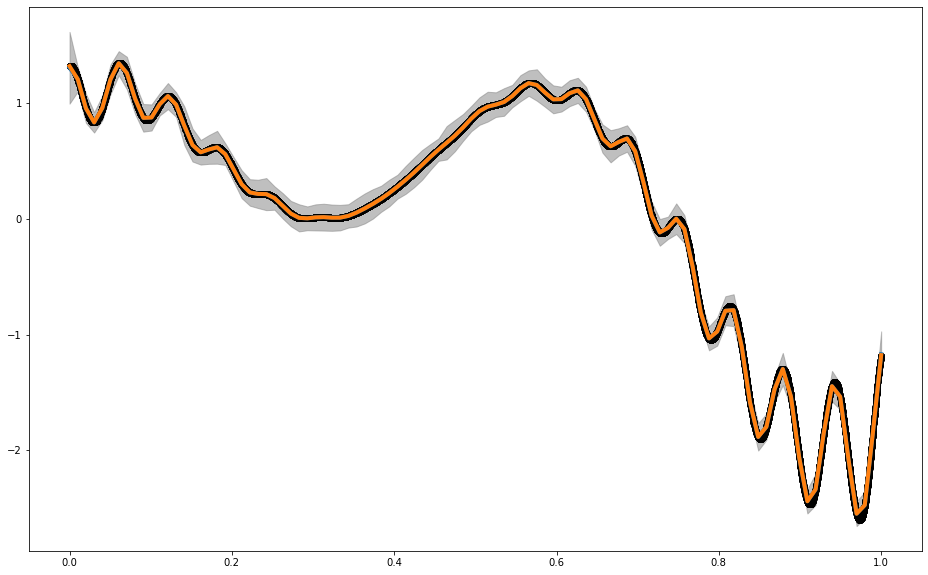

In [5]:
x_pred = np.linspace(0,1,100) ##for big GPs, this is usually not a good idea, but in 1d, we can still do it
                              ##It's better to do predicitons only for a handful of points.

mean1 = my_gp2S.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp2S.posterior_covariance(x_pred.reshape(-1,1), variance_only=False)["v(x)"]

print(my_gp2S.hyperparameters)

plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred,f1(x_pred), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')

In [6]:
my_gp2S.ask(np.array([[0,1]]))

{'x': array([[0.48905055]]), 'f(x)': array([0.00380065]), 'opt_obj': None}